In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.discriminant_analysis import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn import metrics
from enum import Enum, auto

In [106]:
class MyEnum(Enum):
    ITALIAN = auto()
    MDVR = auto()

In [107]:
final_results_df = pd.DataFrame(columns=('accuracy', 'precision', 'recall', 'f1-score'))

In [108]:
#save values to final table
def saveMetricsFinalDf(name, y_test, y_predict):
    final_accuracy = round(classification_report(y_test, y_predict, labels=[1, 0], output_dict=True)['accuracy'],2)
    final_precision = round(classification_report(y_test, y_predict, labels=[1, 0], output_dict=True)['weighted avg']['precision'],2)
    final_recall = round(classification_report(y_test, y_predict, labels=[1, 0], output_dict=True)['weighted avg']['recall'],2)
    final_f1score = round(classification_report(y_test, y_predict, labels=[1, 0], output_dict=True)['weighted avg']['f1-score'],2)
    final_results_df.loc[name] = [final_accuracy, final_precision, final_recall, final_f1score]

# Model Building

In [109]:
selected_option = MyEnum.ITALIAN

if selected_option == MyEnum.ITALIAN:
    features_df = pd.read_csv("../data/tables/italian_features.csv")
    reduced_features_df = pd.read_csv("../data/tables/italian_reduced_features.csv")
elif selected_option == MyEnum.MDVR:
    features_df = pd.read_csv("../data/tables/mdvr_features.csv")
    reduced_features_df = pd.read_csv("../data/tables/mdvr_reduced_features.csv")
else:
    print("Unknown option")



In [110]:
features_df

,meanF0,stdevF0,hnr,localJitter,localabsoluteJitter,rapJitter,ppq5Jitter,ddpJitter,localShimmer,localdbShimmer,apq3Shimmer,aqpq5Shimmer,apq11Shimmer,ddaShimmer,PD
0,129.307948,2.064876,23.959287,0.004173,0.000032,0.002187,0.002334,0.006560,0.024436,0.224043,0.011687,0.014726,0.022840,0.035061,1.0
1,122.038081,5.155957,27.957755,0.004510,0.000037,0.002313,0.002498,0.006938,0.014446,0.175230,0.005156,0.006642,0.014389,0.015468,1.0
2,138.828247,2.136906,33.309475,0.002323,0.000017,0.001113,0.001179,0.003339,0.007289,0.068204,0.002894,0.004096,0.006777,0.008682,1.0
3,213.347835,3.371491,26.434427,0.003564,0.000016,0.002018,0.001938,0.006054,0.012845,0.112993,0.005653,0.007224,0.010797,0.016959,1.0
4,146.076736,16.504125,30.583621,0.003027,0.000021,0.001518,0.001504,0.004555,0.011083,0.122816,0.005337,0.005597,0.009463,0.016012,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
488,120.238273,15.841945,31.049953,0.002637,0.000022,0.001333,0.001443,0.004000,0.016649,0.184037,0.006842,0.009043,0.016924,0.020526,0.0
489,125.702970,3.419908,14.176360,0.006556,0.000052,0.003642,0.003866,0.010925,0.061772,0.595184,0.029273,0.036155,0.059658,0.087818,0.0
490,132.869272,19.792501,12.890455,0.007489,0.000055,0.003827,0.004149,0.011480,0.061772,0.595184,0.029273,0.036155,0.059658,0.087818,0.0
491,213.347835,5.931401,14.642913,0.007489,0.000055,0.003827,0.004233,0.011480,0.061772,0.595184,0.029273,0.036155,0.059658,0.087818,0.0


In [111]:

reduced_features_df

,meanF0,stdevF0,hnr,localJitter,localabsoluteJitter,rapJitter,ppq5Jitter,ddpJitter,localShimmer,localdbShimmer,apq3Shimmer,aqpq5Shimmer,apq11Shimmer,ddaShimmer
0,129.307948,2.064876,23.959287,0.004173,0.000032,0.002187,0.002334,0.006560,0.024436,0.224043,0.011687,0.014726,0.022840,0.035061
1,122.038081,5.155957,27.957755,0.004510,0.000037,0.002313,0.002498,0.006938,0.014446,0.175230,0.005156,0.006642,0.014389,0.015468
2,138.828247,2.136906,33.309475,0.002323,0.000017,0.001113,0.001179,0.003339,0.007289,0.068204,0.002894,0.004096,0.006777,0.008682
3,213.347835,3.371491,26.434427,0.003564,0.000016,0.002018,0.001938,0.006054,0.012845,0.112993,0.005653,0.007224,0.010797,0.016959
4,146.076736,16.504125,30.583621,0.003027,0.000021,0.001518,0.001504,0.004555,0.011083,0.122816,0.005337,0.005597,0.009463,0.016012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
488,120.238273,15.841945,31.049953,0.002637,0.000022,0.001333,0.001443,0.004000,0.016649,0.184037,0.006842,0.009043,0.016924,0.020526
489,125.702970,3.419908,14.176360,0.006556,0.000052,0.003642,0.003866,0.010925,0.061772,0.595184,0.029273,0.036155,0.059658,0.087818
490,132.869272,19.792501,12.890455,0.007489,0.000055,0.003827,0.004149,0.011480,0.061772,0.595184,0.029273,0.036155,0.059658,0.087818
491,213.347835,5.931401,14.642913,0.007489,0.000055,0.003827,0.004233,0.011480,0.061772,0.595184,0.029273,0.036155,0.059658,0.087818


In [112]:
# lets build our classification model
# independent variables
X = reduced_features_df
# X=pd.DataFrame(X_stand1)
# the dependent variable
y = features_df['PD']

In [113]:
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.30,random_state=1)

In [114]:
print("{0:0.2f}% data is in training set".format((len(X_train)/len(reduced_features_df.index)) * 100))
print("{0:0.2f}% data is in test set".format((len(X_test)/len(reduced_features_df.index)) * 100))

69.98% data is in training set
30.02% data is in test set


In [115]:
y_train_yPD=y_train[y_train==1].count()
y_train_nPD=y_train[y_train==0].count()
y_test_yPD=y_test[y_test==1].count()
y_test_nPD=y_test[y_test==0].count()

print("In the original dataset people who had parkinson Dieases    : {0} ({1:0.2f}%)".format(len(reduced_features_df.loc[features_df['PD'] == 1]), (len(reduced_features_df.loc[features_df['PD'] == 1])/len(reduced_features_df.index)) * 100))
print("In the original dataset people who didnot have Parkinson Disease   : {0} ({1:0.2f}%)".format(len(reduced_features_df.loc[features_df['PD'] == 0]), (len(reduced_features_df.loc[features_df['PD'] == 0])/len(reduced_features_df.index)) * 100))
print("")
print("In the training dataset people who who had parkinson Dieases    : {0} ({1:0.2f}%)".format(y_train_yPD, (y_train_yPD/len(y_train))*100))
print("In the training dataset people who didnot have Parkinson Disease    : {0} ({1:0.2f}%)".format(y_train_nPD, (y_train_nPD/len(y_train))*100))
print("")
print("In the test dataset people who who had parkinson Dieases    : {0} ({1:0.2f}%)".format(y_test_yPD, (y_test_yPD/len(y_test))*100))
print("In the test dataset people who didnot have Parkinson Disease    : {0} ({1:0.2f}%)".format(y_test_nPD, (y_test_nPD/len(y_test))*100))

In the original dataset people who had parkinson Dieases    : 274 (55.58%)
In the original dataset people who didnot have Parkinson Disease   : 219 (44.42%)

In the training dataset people who who had parkinson Dieases    : 199 (57.68%)
In the training dataset people who didnot have Parkinson Disease    : 146 (42.32%)

In the test dataset people who who had parkinson Dieases    : 75 (50.68%)
In the test dataset people who didnot have Parkinson Disease    : 73 (49.32%)


Scales impact

Gradient descent based algorithms like Linear Regression, Logistics Regression
Distance based algorithms like KNN, K-means and SVM
Scales dont impact:

Tree based algorithms like Decision trees

In [116]:
# lets create a copy of the train and test data for scaling


X_Train_stand = X_train.copy()
X_Test_stand = X_test.copy()
# we will use standard scaler for scaling the data.
scale = StandardScaler().fit(X_Train_stand)
X_train= scale.transform(X_Train_stand)
X_test= scale.transform(X_Test_stand)

In [117]:
if (pd.DataFrame(X_train).isnull().sum().any()==0):
    print('There are no null values in the training datset')
else:
    print('There are null values in the training datset')

if (pd.DataFrame(X_test).isnull().sum().any()==0):
    print('There are no null values in the test datset')
else:
    print('There are null values in the test datset')

There are no null values in the training datset
There are no null values in the test datset


# Logistic Regression

Probabilities for the positive class:
[0.00362532 0.70792022 0.90449672 0.78822078 0.00807772 0.88589633
 0.57095807 0.87523301 0.81908432 0.11086705 0.97590893 0.81117455
 0.87661393 0.99792925 0.46973435 0.10193262 0.15159931 0.08783325
 0.98870772 0.76535315 0.07129745 0.83845058 0.27165206 0.02774642
 0.91336074 0.65464175 0.06440713 0.00771596 0.98356052 0.17662127
 0.85217951 0.87634002 0.85731748 0.8326504  0.18102619 0.28887582
 0.75212103 0.26320008 0.94473631 0.90479813 0.18591273 0.80932183
 0.24419168 0.74445364 0.17395725 0.63143989 0.91292113 0.46763053
 0.8125082  0.4941359  0.98033303 0.21847396 0.25329429 0.00993823
 0.84743295 0.86148838 0.25227808 0.1037004  0.27132101 0.07363534
 0.71157891 0.64407389 0.00517605 0.03731492 0.02710466 0.10181552
 0.00646396 0.89392994 0.92455357 0.95775423 0.84386301 0.83837419
 0.09721873 0.41645851 0.00742828 0.37520436 0.51207485 0.28055273
 0.7227307  0.98757551 0.96147264 0.34934529 0.18655612 0.00591023
 0.73261585 0.22674544 0

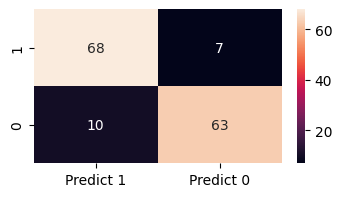

In [118]:
# Fit the model on train data
model = LogisticRegression(solver="liblinear")
model.fit(X_train,y_train)

# Predict probabilities on the test data
y_predict_proba_lr = model.predict_proba(X_test)

# y_predict_proba_lr is an array where each row contains the probability estimates for each class
# Assuming you are interested in the probability of the positive class (class 1)
positive_class_probabilities = y_predict_proba_lr[:, 1]

# Print or use the probabilities as needed
print("Probabilities for the positive class:")
print(positive_class_probabilities)

# predict on the test data
y_predict_lr = model.predict(X_test)
y_predict_lr

coef_df = pd.DataFrame(model.coef_)
coef_df['intercept'] = model.intercept_
coef_df

model_score_lr = model.score(X_test, y_test)
print("Model Accuracy of Logistic Regression is: {0:.4f}".format(model_score_lr))
print()

print("Confusion Matrix - Logistic Regression")
cm=metrics.confusion_matrix(y_test, y_predict_lr, labels=[1, 0])

df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (4,2))
sns.heatmap(df_cm, annot=True)

print("Classification Report - Logistic Regression")
print(metrics.classification_report(y_test, y_predict_lr, labels=[1, 0]))

In [119]:
saveMetricsFinalDf('Logistic Regression', y_test, y_predict_lr)

# Logistic Regression with Hyperparameter tuning

Best Score: 0.8202240896358544
Best Hyperparameters: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
{'solver': ['newton-cg', 'lbfgs', 'liblinear'], 'penalty': ['l2'], 'C': [100, 10, 1.0, 0.1, 0.01]}
87.16216216216216
              precision    recall  f1-score   support

         0.0       0.91      0.82      0.86        73
         1.0       0.84      0.92      0.88        75

    accuracy                           0.87       148
   macro avg       0.88      0.87      0.87       148
weighted avg       0.87      0.87      0.87       148

0.870958904109589
[0. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0.
 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0.
 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1.
 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1.
 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1.
 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0.

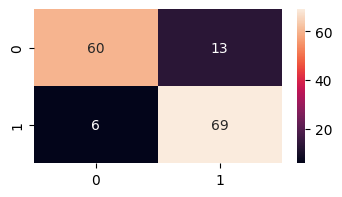

In [120]:
########Hyperparameter tuning for SVM####################
#List Hyperparameters that we want to tune.
#n_components = list(range(1,X.shape[1]+1,1))
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

#Convert to dictionary
hyperparameters = dict(solver=solvers,penalty=penalty,C=c_values)
#Create new LR object
model_lr2 = LogisticRegression()

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

#Use GridSearch
clf = GridSearchCV(model_lr2, hyperparameters, cv=cv)

#clf = RandomizedSearchCV(knn_2, hyperparameters, n_iter=500, cv=8, scoring="recall")
#Fit the model
best_model = clf.fit(X_train, y_train)
#Print The value of best Hyperparameters
#print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
#print('Best p:', best_model.best_estimator_.get_params()['p'])
#print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])
print('Best Score: %s' % best_model.best_score_)
print('Best Hyperparameters: %s' % best_model.best_params_)
print(hyperparameters)
y_pred_lr_2 = best_model.predict(X_test)

conf_matrix_knn_2 = confusion_matrix(y_test, y_pred_lr_2)

accuracy_knn_2 = ((conf_matrix_knn_2[0,0] + conf_matrix_knn_2[1,1])/(conf_matrix_knn_2[0,0] +conf_matrix_knn_2[0,1]+conf_matrix_knn_2[1,0]+conf_matrix_knn_2[1,1]))*100

plt.figure(figsize = (4,2))
sns.heatmap(conf_matrix_knn_2, annot=True)

print(accuracy_knn_2)

#Checking performance our model with classification report.
print(classification_report(y_test, y_pred_lr_2))
#Checking performance our model with ROC Score.
print(roc_auc_score(y_test, y_pred_lr_2))

print(y_pred_lr_2)

print(y_test)

saveMetricsFinalDf('Logistic Regression (HPT)', y_test, y_pred_lr_2)

# KNN

In [121]:
# Call Nearest Neighbour algorithm and fit the model on train data
NNH = KNeighborsClassifier(n_neighbors= 5 , weights = 'distance' )
NNH.fit(X_train, np.ravel(y_train,order='C'))

KNeighborsClassifier(weights='distance')

In [122]:
# For every test data point, predict it's label based on 5 nearest neighbours in this model. 
#The majority class will be assigned to the test data point

y_predict_knn = NNH.predict(X_test)
model_score_knn = NNH.score(X_test, y_test)

print("Model Accuracy of KNN is: {0:.4f}".format(model_score_knn))
print()

Model Accuracy of KNN is: 0.9054



Confusion Matrix - KNN


<Axes: >

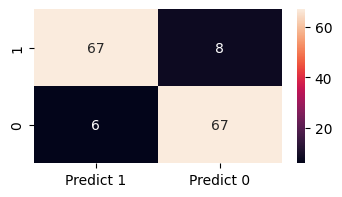

In [123]:
print("Confusion Matrix - KNN")
cm=metrics.confusion_matrix(y_test, y_predict_knn, labels=[1, 0])
df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (4,2))
sns.heatmap(df_cm, annot=True)

In [124]:
print("Classification Report - KNN")
print(metrics.classification_report(y_test, y_predict_knn, labels=[1, 0]))

saveMetricsFinalDf('KNN', y_test, y_predict_knn)

Classification Report - KNN
              precision    recall  f1-score   support

           1       0.92      0.89      0.91        75
           0       0.89      0.92      0.91        73

    accuracy                           0.91       148
   macro avg       0.91      0.91      0.91       148
weighted avg       0.91      0.91      0.91       148



# KNN with hyperparameter tuning

Best leaf_size: 1
Best p: 2
Best n_neighbors: 7
Best Score: 0.8379831932773107
Best Hyperparameters: {'leaf_size': 1, 'n_neighbors': 7, 'p': 2}
{'leaf_size': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49], 'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], 'p': [1, 2]}
88.51351351351352
              precision    recall  f1-score   support

         0.0       0.88      0.89      0.88        73
         1.0       0.89      0.88      0.89        75

    accuracy                           0.89       148
   macro avg       0.89      0.89      0.89       148
weighted avg       0.89      0.89      0.89       148

0.8852054794520547
[0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0.
 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0.
 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 

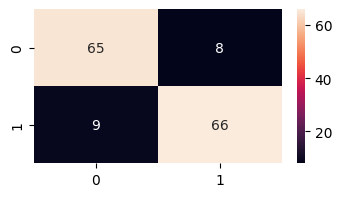

In [125]:
leaf_size = list(range(1,50))
n_neighbors = list(range(1,20)) #neighbours must be < number of samples (22)
p=[1,2]
#Convert to dictionary
hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)
#Create new KNN object
knn_2 = KNeighborsClassifier()

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

#Use GridSearch
clf = GridSearchCV(knn_2, hyperparameters, cv=10)

#clf = RandomizedSearchCV(knn_2, hyperparameters, n_iter=500, cv=8, scoring="recall")
#Fit the model
best_model = clf.fit(X_train, y_train)
#Print The value of best Hyperparameters
print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
print('Best p:', best_model.best_estimator_.get_params()['p'])
print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])
print('Best Score: %s' % best_model.best_score_)
print('Best Hyperparameters: %s' % best_model.best_params_)
print(hyperparameters)
y_pred_knn_2 = best_model.predict(X_test)

conf_matrix_knn_2 = confusion_matrix(y_test, y_pred_knn_2)

accuracy_knn_2 = ((conf_matrix_knn_2[0,0] + conf_matrix_knn_2[1,1])/(conf_matrix_knn_2[0,0] +conf_matrix_knn_2[0,1]+conf_matrix_knn_2[1,0]+conf_matrix_knn_2[1,1]))*100


print(accuracy_knn_2)

#Checking performance our model with classification report.
print(classification_report(y_test, y_pred_knn_2))
#Checking performance our model with ROC Score.
print(roc_auc_score(y_test, y_pred_knn_2))

print(y_pred_knn_2)
print(y_test)

plt.figure(figsize = (4,2))
sns.heatmap(conf_matrix_knn_2, annot=True)

saveMetricsFinalDf('KNN (HPT)', y_test, y_pred_knn_2)

# Naive Bayes

### No important parameters to tune

In [126]:
NB_model = GaussianNB()
NB_model.fit(X_train, y_train)

GaussianNB()

In [127]:
y_predict_nb = NB_model.predict(X_test)
model_score_nb=metrics.accuracy_score(y_test, y_predict_nb)

print("Model Accuracy of Naive Bayes is: {0:.4f}".format(model_score_nb))
print()

Model Accuracy of Naive Bayes is: 0.7770



Confusion Matrix - Naive Bayes


<Axes: >

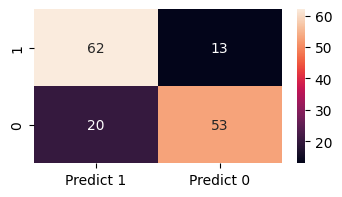

In [128]:
print("Confusion Matrix - Naive Bayes")
cm=metrics.confusion_matrix(y_test, y_predict_nb, labels=[1, 0])
df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (4,2))
sns.heatmap(df_cm, annot=True)

In [129]:
print("Classification Report - Naive Bayes")
print(metrics.classification_report(y_test, y_predict_nb, labels=[1, 0]))

saveMetricsFinalDf('NB', y_test, y_predict_nb)

Classification Report - Naive Bayes
              precision    recall  f1-score   support

           1       0.76      0.83      0.79        75
           0       0.80      0.73      0.76        73

    accuracy                           0.78       148
   macro avg       0.78      0.78      0.78       148
weighted avg       0.78      0.78      0.78       148



# SVM

In [130]:
clf = svm.SVC(gamma=0.025, C=3) 

In [131]:
clf.fit(X_train , y_train)

SVC(C=3, gamma=0.025)

In [132]:
y_predict_svm = clf.predict(X_test)

In [133]:
model_score_svm=metrics.accuracy_score(y_test, y_predict_svm)

print("Model Accuracy of SVM is: {0:.4f}".format(model_score_svm))
print()

Model Accuracy of SVM is: 0.8446



Confusion Matrix - SVM


<Axes: >

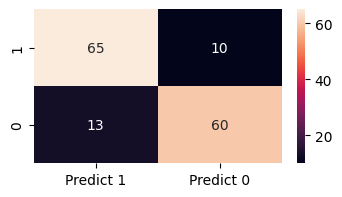

In [134]:
print("Confusion Matrix - SVM")
cm=metrics.confusion_matrix(y_test, y_predict_svm, labels=[1, 0])
df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (4,2))
sns.heatmap(df_cm, annot=True)

In [135]:
print("Classification Report - SVM")
print(metrics.classification_report(y_test, y_predict_svm, labels=[1, 0]))

saveMetricsFinalDf('SVM', y_test, y_predict_svm)

Classification Report - SVM
              precision    recall  f1-score   support

           1       0.83      0.87      0.85        75
           0       0.86      0.82      0.84        73

    accuracy                           0.84       148
   macro avg       0.85      0.84      0.84       148
weighted avg       0.85      0.84      0.84       148



# SVM with hyperparameter tuning

Best Score: 0.846376811594203
Best Hyperparameters: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
{'C': [0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf']}
91.8918918918919
              precision    recall  f1-score   support

         0.0       0.94      0.89      0.92        73
         1.0       0.90      0.95      0.92        75

    accuracy                           0.92       148
   macro avg       0.92      0.92      0.92       148
weighted avg       0.92      0.92      0.92       148

0.9185388127853882
[0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0.
 1. 0. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0.
 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0.
 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1.
 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 0.
 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1.
 1. 0. 1. 1.]
354  

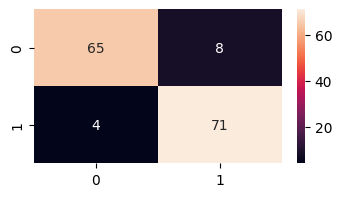

In [136]:
########Hyperparameter tuning for SVM####################
#List Hyperparameters that we want to tune.
#n_components = list(range(1,X.shape[1]+1,1))
C = [0.1, 1, 10, 100, 1000]
gamma = [1, 0.1, 0.01, 0.001, 0.0001]
kernel = ['rbf']

#Convert to dictionary
hyperparameters = dict(C=C, gamma=gamma, kernel=kernel)
#Create new SVM object
svm2 = svm.SVC()

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

#Use GridSearch
clf = GridSearchCV(svm2, hyperparameters, refit=True)

#clf = RandomizedSearchCV(knn_2, hyperparameters, n_iter=500, cv=8, scoring="recall")
#Fit the model
best_model = clf.fit(X_train, y_train)
#Print The value of best Hyperparameters
#print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
#print('Best p:', best_model.best_estimator_.get_params()['p'])
#print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])
print('Best Score: %s' % best_model.best_score_)
print('Best Hyperparameters: %s' % best_model.best_params_)
print(hyperparameters)
y_pred_svm_2 = best_model.predict(X_test)

conf_matrix_svm_2 = confusion_matrix(y_test, y_pred_svm_2)

accuracy_svm_2 = ((conf_matrix_svm_2[0,0] + conf_matrix_svm_2[1,1])/(conf_matrix_svm_2[0,0] +conf_matrix_svm_2[0,1]+conf_matrix_svm_2[1,0]+conf_matrix_svm_2[1,1]))*100


print(accuracy_svm_2)

#Checking performance our model with classification report.
print(classification_report(y_test, y_pred_svm_2))
#Checking performance our model with ROC Score.
print(roc_auc_score(y_test, y_pred_svm_2))

print(y_pred_svm_2)
print(y_test)

plt.figure(figsize = (4,2))
sns.heatmap(conf_matrix_svm_2, annot=True)

saveMetricsFinalDf('SVM (HPT)', y_test, y_pred_svm_2)

# Random Forest

In [137]:
model_rf = RandomForestClassifier(n_estimators = 50,random_state=1,max_features=3) 
model_rf = model_rf.fit(X_train, y_train)

In [138]:
y_predict_rf = model_rf.predict(X_test)
print(model_rf.score(X_test, y_test))

0.8716216216216216


Confusion Matrix -Random Forest


<Axes: >

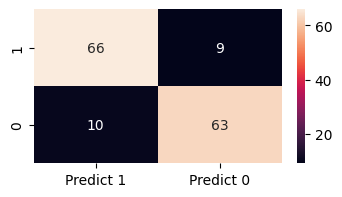

In [139]:
print("Confusion Matrix -Random Forest")
cm=metrics.confusion_matrix(y_test, y_predict_rf, labels=[1, 0])
df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (4,2))
sns.heatmap(df_cm, annot=True)

In [140]:
print("Classification Report - Random Forest")
print(metrics.classification_report(y_test, y_predict_rf, labels=[1, 0]))

saveMetricsFinalDf('Random Forest', y_test, y_predict_rf)

Classification Report - Random Forest
              precision    recall  f1-score   support

           1       0.87      0.88      0.87        75
           0       0.88      0.86      0.87        73

    accuracy                           0.87       148
   macro avg       0.87      0.87      0.87       148
weighted avg       0.87      0.87      0.87       148



# Random Forest with Hyperparameter Tuning

In [141]:
#TODO

# Bagging

In [142]:
bgcl = BaggingClassifier(n_estimators=50,random_state=1)
bgcl = bgcl.fit(X_train, y_train)

In [143]:
y_predict_bag = bgcl.predict(X_test)
print(bgcl.score(X_test , y_test))

0.8648648648648649


Confusion Matrix -Bagging Classifier


<Axes: >

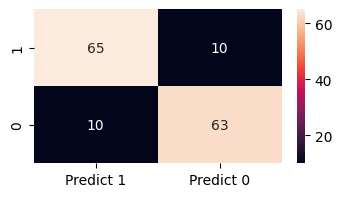

In [144]:
print("Confusion Matrix -Bagging Classifier")
cm=metrics.confusion_matrix(y_test, y_predict_bag, labels=[1, 0])
df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (4,2))
sns.heatmap(df_cm, annot=True)



In [145]:
print("Classification Report - Bagging Classifier")
print(metrics.classification_report(y_test, y_predict_bag, labels=[1, 0]))

saveMetricsFinalDf('Bagging', y_test, y_predict_bag)

Classification Report - Bagging Classifier
              precision    recall  f1-score   support

           1       0.87      0.87      0.87        75
           0       0.86      0.86      0.86        73

    accuracy                           0.86       148
   macro avg       0.86      0.86      0.86       148
weighted avg       0.86      0.86      0.86       148



# Bagging with Hyperparameter Tuning

Best Hyperparameters: {'n_estimators': 50}
Best Model Accuracy: 0.8648648648648649
Confusion Matrix - Bagging Classifier
Classification Report - Bagging Classifier
              precision    recall  f1-score   support

           1       0.87      0.87      0.87        75
           0       0.86      0.86      0.86        73

    accuracy                           0.86       148
   macro avg       0.86      0.86      0.86       148
weighted avg       0.86      0.86      0.86       148



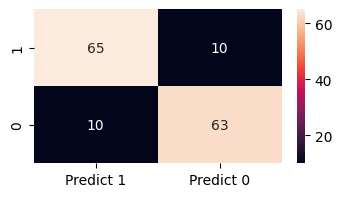

In [146]:
#TESTE


# Define the Bagging Classifier with hyperparameters to be tuned
bgcl = BaggingClassifier(random_state=1)

# Define the hyperparameters grid to search
param_grid = {
    'n_estimators': [10, 20, 30, 40, 50],  # Adjust the number of estimators
    # You can add more hyperparameters to tune here
}

# Define the scoring method, e.g., accuracy
scoring = make_scorer(accuracy_score)

# Create the Grid Search object
grid_search = GridSearchCV(bgcl, param_grid, scoring=scoring, cv=5)

# Fit the Grid Search to your training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best Bagging Classifier model
best_bgcl = grid_search.best_estimator_

# Fit the best model on the training data
best_bgcl.fit(X_train, y_train)

# Make predictions on the test set
y_predict_bag_2 = best_bgcl.predict(X_test)

# Print the accuracy of the best model on the test set
accuracy = best_bgcl.score(X_test, y_test)
print("Best Model Accuracy:", accuracy)

# Compute and print the confusion matrix
print("Confusion Matrix - Bagging Classifier")
cm = confusion_matrix(y_test, y_predict_bag_2, labels=[1, 0])
df_cm = pd.DataFrame(cm, index=["1", "0"], columns=["Predict 1", "Predict 0"])
plt.figure(figsize=(4, 2))
sns.heatmap(df_cm, annot=True)

# Print the classification report
print("Classification Report - Bagging Classifier")
print(classification_report(y_test, y_predict_bag_2, labels=[1, 0]))

saveMetricsFinalDf('Bagging (HPT)', y_test, y_predict_bag_2)


# AdaBoost

In [147]:
AdaBC = AdaBoostClassifier(n_estimators=50, random_state=1)
#abcl = AdaBoostClassifier( n_estimators=50,random_state=1)
AdaBC = AdaBC.fit(X_train, y_train)

In [148]:
y_predict_ada = AdaBC.predict(X_test)
print(AdaBC.score(X_test , y_test))

0.8445945945945946


Confusion Matrix -Ada Boost


<Axes: >

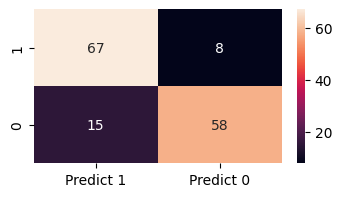

In [149]:
print("Confusion Matrix -Ada Boost")
cm=metrics.confusion_matrix(y_test, y_predict_ada, labels=[1, 0])
df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (4,2))
sns.heatmap(df_cm, annot=True)

In [150]:
print("Classification Report - Ada Boost")
print(metrics.classification_report(y_test, y_predict_ada, labels=[1, 0]))

saveMetricsFinalDf('AdaBoost', y_test, y_predict_ada)

Classification Report - Ada Boost
              precision    recall  f1-score   support

           1       0.82      0.89      0.85        75
           0       0.88      0.79      0.83        73

    accuracy                           0.84       148
   macro avg       0.85      0.84      0.84       148
weighted avg       0.85      0.84      0.84       148



# AdaBoost with Hyperparameter Tuning

Best Hyperparameters: {'n_estimators': 20}
Best Model Accuracy: 0.8581081081081081
Confusion Matrix - Ada Boost
Classification Report - Ada Boost
              precision    recall  f1-score   support

           1       0.86      0.85      0.86        75
           0       0.85      0.86      0.86        73

    accuracy                           0.86       148
   macro avg       0.86      0.86      0.86       148
weighted avg       0.86      0.86      0.86       148



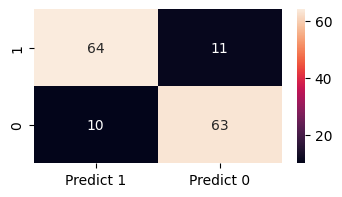

In [151]:
#TESTE


# Define the AdaBoost Classifier with hyperparameters to be tuned
AdaBC = AdaBoostClassifier(random_state=1)

# Define the hyperparameters grid to search
param_grid = {
    'n_estimators': [10, 20, 30, 40, 50],  # Adjust the number of estimators
    # You can add more hyperparameters to tune here
}

# Define the scoring method, e.g., accuracy
scoring = make_scorer(accuracy_score)

# Create the Grid Search object
grid_search = GridSearchCV(AdaBC, param_grid, scoring=scoring, cv=5)

# Fit the Grid Search to your training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best AdaBoost Classifier model
best_AdaBC = grid_search.best_estimator_

# Fit the best model on the training data
best_AdaBC.fit(X_train, y_train)

# Make predictions on the test set
y_predict_ada_2 = best_AdaBC.predict(X_test)

# Print the accuracy of the best model on the test set
accuracy = best_AdaBC.score(X_test, y_test)
print("Best Model Accuracy:", accuracy)

# Compute and print the confusion matrix
print("Confusion Matrix - Ada Boost")
cm = confusion_matrix(y_test, y_predict_ada_2, labels=[1, 0])
df_cm = pd.DataFrame(cm, index=["1", "0"], columns=["Predict 1", "Predict 0"])
plt.figure(figsize=(4, 2))
sns.heatmap(df_cm, annot=True)

# Print the classification report
print("Classification Report - Ada Boost")
print(classification_report(y_test, y_predict_ada_2, labels=[1, 0]))

saveMetricsFinalDf('AdaBoost (HPT)', y_test, y_predict_ada_2)


# XG Boost

In [152]:
model = XGBClassifier(random_state=0, learning_rate=0.1, n_estimators=100, max_depth=4)
model = model.fit(X_train, y_train)
y_predict_XGB = model.predict(X_test)
print('The accuracy of the XGB Classifier is: [%.8f]' % accuracy_score(y_test, y_predict_XGB))

/Users/tomas/Documents/Tese/Predictive-models-Parkinson/src/venv/lib/python3.11/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


The accuracy of the XGB Classifier is: [0.86486486]


Confusion Matrix - XGB Classifier


<Axes: >

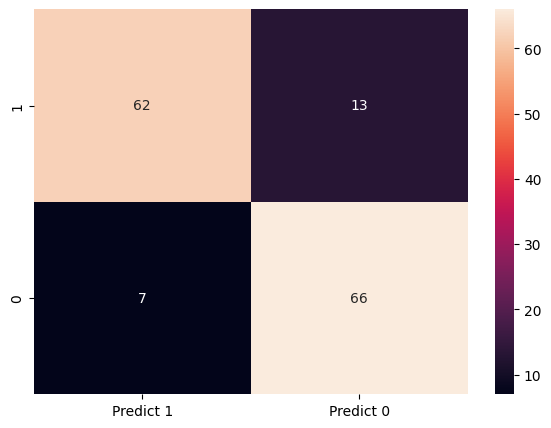

In [153]:
print("Confusion Matrix - XGB Classifier")
cm=metrics.confusion_matrix(y_test, y_predict_XGB, labels=[1, 0])
df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True)

In [154]:
print("Classification Report - XGB Classifier")
print(metrics.classification_report(y_test, y_predict_XGB, labels=[1, 0]))

saveMetricsFinalDf('XGBoost', y_test, y_predict_XGB)

Classification Report - XGB Classifier
              precision    recall  f1-score   support

           1       0.90      0.83      0.86        75
           0       0.84      0.90      0.87        73

    accuracy                           0.86       148
   macro avg       0.87      0.87      0.86       148
weighted avg       0.87      0.86      0.86       148



# XGBoost with Hyperparameter tuning

/Users/tomas/Documents/Tese/Predictive-models-Parkinson/src/venv/lib/python3.11/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


/Users/tomas/Documents/Tese/Predictive-models-Parkinson/src/venv/lib/python3.11/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/tomas/Documents/Tese/Predictive-models-Parkinson/src/venv/lib/python3.11/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/tomas/Documents/Tese/Predictive-models-Parkinson/src/venv/lib/python3.11/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/tomas/Documents/Tese/Predictive-models-Parkinson/src/venv/lib/python3.11/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. C

Best Hyperparameters: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 200}
The accuracy of the XGB Classifier is: [0.87162162]
Confusion Matrix - XGB Classifier
Classification Report - XGB Classifier
              precision    recall  f1-score   support

           1       0.88      0.87      0.87        75
           0       0.86      0.88      0.87        73

    accuracy                           0.87       148
   macro avg       0.87      0.87      0.87       148
weighted avg       0.87      0.87      0.87       148



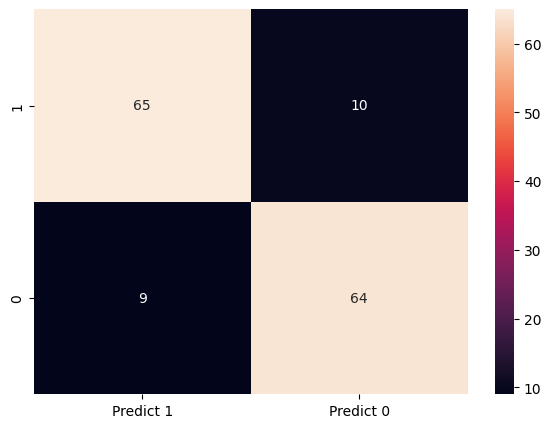

In [155]:

# Define the XGBClassifier with hyperparameters to be tuned
model = XGBClassifier(random_state=0)

# Define the hyperparameters grid to search
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],  # Adjust the learning rate
    'n_estimators': [50, 100, 200],  # Adjust the number of estimators
    'max_depth': [3, 4, 5]  # Adjust the maximum depth of trees
    # You can add more hyperparameters to tune here
}

# Define the scoring method, e.g., accuracy
scoring = make_scorer(accuracy_score)

# Create the Grid Search object
grid_search = GridSearchCV(model, param_grid, scoring=scoring, cv=5)

# Fit the Grid Search to your training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best XGBClassifier model
best_model = grid_search.best_estimator_

# Fit the best model on the training data
best_model.fit(X_train, y_train)


# Make predictions on the test set
y_predict_XGB_2 = best_model.predict(X_test)

# Print the accuracy of the best model on the test set
accuracy = accuracy_score(y_test, y_predict_XGB_2)
print('The accuracy of the XGB Classifier is: [%.8f]' % accuracy)

# Compute and print the confusion matrix
print("Confusion Matrix - XGB Classifier")
cm = confusion_matrix(y_test, y_predict_XGB_2, labels=[1, 0])
df_cm = pd.DataFrame(cm, index=["1", "0"], columns=["Predict 1", "Predict 0"])
plt.figure(figsize=(7, 5))
sns.heatmap(df_cm, annot=True)

# Print the classification report
print("Classification Report - XGB Classifier")
print(classification_report(y_test, y_predict_XGB_2, labels=[1, 0]))


saveMetricsFinalDf('XGBoost (HPT)', y_test, y_predict_XGB_2)



# Final Results

In [156]:
(final_results_df)

,accuracy,precision,recall,f1-score
Logistic Regression,0.89,0.89,0.89,0.89
Logistic Regression (HPT),0.87,0.87,0.87,0.87
KNN,0.91,0.91,0.91,0.91
KNN (HPT),0.89,0.89,0.89,0.89
NB,0.78,0.78,0.78,0.78
SVM,0.84,0.85,0.84,0.84
SVM (HPT),0.92,0.92,0.92,0.92
Random Forest,0.87,0.87,0.87,0.87
Bagging,0.86,0.86,0.86,0.86
Bagging (HPT),0.86,0.86,0.86,0.86
